In [1]:
import time
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from numpy.linalg import norm

import matplotlib.pyplot as plt

from custom_lib.build_vgg import build_cifar_model
from custom_lib.triplet_utils import buildDataSet

from keras.datasets import cifar10
from keras.utils import to_categorical

from art.classifiers import KerasClassifier
from art.attacks.fast_gradient import FastGradientMethod
from art.attacks.carlini import CarliniL2Method
from art.attacks.projected_gradient_descent import ProjectedGradientDescent

import time

Using TensorFlow backend.


In [2]:
num_classes = 10
weight_decay = 0.005
x_shape = [32,32,3]

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [3]:
nb_classes = 10
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

dataset_train, dataset_test, x_train_origin, y_train_origin, x_test_origin, y_test_origin = buildDataSet(cifar=True)

In [4]:
import psutil

p = psutil.Process()

for i in p.threads():
    temp = psutil.Process(i.id)

    temp.cpu_affinity([i for i in range(8)])

## Base Network

In [8]:
model = build_cifar_model(num_classes, x_shape, conv_dropout=0.1 , dense_dropout=0.1)

model.load_weights('/data1/Henry/cifar10vgg.h5')

op = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

pen_output = K.function([model.layers[0].input, K.learning_phase()],[model.layers[-5].output])

In [11]:
art_model = KerasClassifier(clip_values=(0, 1.), model=model, use_logits=False)
attack = ProjectedGradientDescent(art_model, norm=2, random_eps=7, batch_size=32)

adv_x = attack.generate(x_test)

In [12]:
print(model.evaluate(x_test, y_test))
print(model.evaluate(adv_x, y_test))

10000/10000 [==============================] - 2s 184us/step
[2.510446421813965, 0.9299]
10000/10000 [==============================] - 2s 171us/step
[11.238630561065674, 0.1793]


[[16.361 16.902 17.127 20.84  18.275 17.861 17.794 18.948 14.643 16.338]
 [18.231 14.361 18.76  20.688 19.247 18.85  18.036 19.142 17.274 11.797]
 [14.246 18.299 17.316 20.016 16.426 19.021 16.384 19.265 17.642 18.073]
 [17.825 17.905 16.89  18.128 17.024 12.74  15.927 18.93  16.84  16.881]
 [17.958 18.147 16.729 19.611  9.554 19.688 18.104 16.713 17.306 17.791]
 [19.809 18.829 18.915 17.642 19.153 19.895 19.887 18.249 19.712 18.991]
 [18.257 18.16  17.082 18.675 18.267 18.484 17.837 19.852 17.688 17.828]
 [19.131 18.387 18.728 18.365 17.109 19.133 18.941 18.881 18.801 18.106]
 [16.919 16.281 17.437 20.773 18.694 18.194 17.135 18.295 14.645 16.048]
 [17.025 16.604 17.924 18.384 18.726 19.201 17.316 18.867 15.389 15.273]]


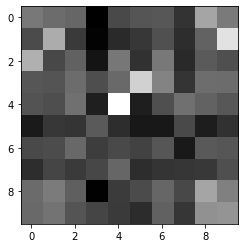

In [22]:
dist_matrix = np.zeros(shape=(10, 10))

for i in range(10):
    start = time.time()
    outs_1 = pen_output([dataset_train[i]])[0]
    print(i)
    for j in range(10):
        outs_2 = pen_output([attack.generate(dataset_train[j][:2000])])[0]
        norms = []
        for k in range(1000):
            norms.append(norm(outs_1[
                np.random.randint(0, 5000)] - outs_2[
                np.random.randint(0, 2000)]))
        dist_matrix[i][j] = np.mean(norms)
    end = time.time()
    print(end-start)

print(dist_matrix.round(3))

plt.imshow(dist_matrix / dist_matrix.max(), cmap="Greys")
plt.show()

## Full Adv Trained

In [4]:
model = build_cifar_model(num_classes, x_shape, conv_dropout=0.1 , dense_dropout=0.1)

model.load_weights('/data1/Henry/adv_full.h5')

op = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

pen_output = K.function([model.layers[0].input, K.learning_phase()],[model.layers[-5].output])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
art_model = KerasClassifier(clip_values=(0, 1.), model=model, use_logits=False)
attack = ProjectedGradientDescent(art_model, norm=2, random_eps=7, batch_size=32)

adv_x = attack.generate(x_test)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [6]:
print(model.evaluate(x_test, y_test))
print(model.evaluate(adv_x, y_test))

10000/10000 [==============================] - 3s 265us/step
[1.1162128475189208, 0.8365]
10000/10000 [==============================] - 2s 207us/step
[2.049755135345459, 0.4888]


0
70.72841596603394
1
65.89768767356873
2
64.07165026664734
3
64.69380164146423
4
63.932416915893555
5
63.2187397480011
6
64.15293502807617
7
64.07754397392273
8
63.818849086761475
9
63.02549648284912
[[ 6.952 13.896 10.455 11.383 11.015 11.309 11.167 13.517 10.986 11.249]
 [15.945 11.556 18.392 18.708 18.357 18.768 17.558 19.415 15.029 15.261]
 [10.565 13.424  7.506 10.073  9.474 10.052 10.02  11.657 11.393 12.931]
 [10.066 13.645  9.072  7.203  8.756  7.606  8.555 16.502 10.359 11.028]
 [ 9.284 12.044  7.497  9.451  6.449  8.181  8.036 10.265 11.126 11.34 ]
 [11.825 14.024 10.624  9.927 10.648  9.043 12.498 13.129 11.985 12.474]
 [11.122 11.864 10.279 10.357 10.247 11.329  8.084 12.232 10.618 11.515]
 [27.626 27.631 26.655 26.597 26.588 25.882 26.454 25.204 25.689 28.18 ]
 [11.211 11.865 12.809 13.164 13.184 13.5   12.112 16.331  6.44  12.37 ]
 [11.977 10.874 12.926 12.568 12.627 12.86  12.537 14.81  11.516  6.627]]


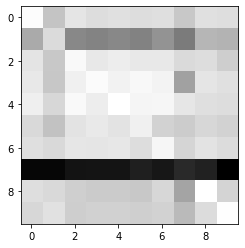

In [7]:
dist_matrix = np.zeros(shape=(10, 10))

for i in range(10):
    start = time.time()
    outs_1 = pen_output([dataset_train[i]])[0]
    print(i)
    for j in range(10):
        outs_2 = pen_output([attack.generate(dataset_train[j][:2000])])[0]
        norms = []
        for k in range(1000):
            norms.append(norm(outs_1[
                np.random.randint(0, 5000)] - outs_2[
                np.random.randint(0, 2000)]))
        dist_matrix[i][j] = np.mean(norms)
    end = time.time()
    print(end-start)

print(dist_matrix.round(3))

plt.imshow(dist_matrix / dist_matrix.max(), cmap="Greys")
plt.show()

## Top Adv Trained

In [4]:
model = build_cifar_model(num_classes, x_shape, conv_dropout=0.1 , dense_dropout=0.1)

model.load_weights('/data1/Henry/adv_top.h5')

op = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

pen_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[-5].output])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
art_model = KerasClassifier(clip_values=(0, 1.), model=model, use_logits=False)
attack = ProjectedGradientDescent(art_model, norm=2, random_eps=7, batch_size=32)

adv_x = attack.generate(x_test)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [6]:
print(model.evaluate(x_test, y_test))
print(model.evaluate(adv_x, y_test))

10000/10000 [==============================] - 3s 285us/step
[2.510446307373047, 0.9299]
10000/10000 [==============================] - 2s 217us/step
[11.331190688323975, 0.1805]
